# Applied Machine Learning

This Jupyter Notebook presents our solution for the Applied ML Homework of the ADA course at EPFL.  

For this homework, we use a [soccer dataset](CrowdstormingDataJuly1st.csv) from a company for sports statistics, containing data from all soccer players (N = 2053) playing in the first male divisions of England, Germany, France and Spain in the 2012-2013 season and all referees (N = 3147) that these players played under in their professional career.

The two main goals of this homework is to:
* Train a random forest classifier that given a soccer player description outputs his skin color
* Use an unsupervised learning technique to cluster the soccer players in 2 disjoint clusters, and try to find if there are relation between the clusters and the players skin color.

In [1]:
import pandas as pd                                     # for dealing with csv import
import numpy as np                                      # arrays and other matlab like manipulation
import os                                               # for joining paths and filenames sensibly
import matplotlib.pyplot as plt                         # Matplotlib's pyplot: MATLAB-like syntax
import scipy.stats.mstats as ssm                        # for bootstrap
from scipy.stats import gaussian_kde as kde
import random

%matplotlib inline
import seaborn as sns                                   # For pretty plots

In [2]:
data = pd.read_csv("data/CrowdstormingDataJuly1st.csv")
data.shape

(146028, 28)

In [3]:

data.ix[:,:13].head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,1,0
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,1,0
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,1,0,0
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,0,0,0
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,0,0,0


In [4]:
data.ix[:,13:].head()

,yellowCards,yellowReds,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,0,0,0,95212.jpg,0.25,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,1,0,0,1663.jpg,0.75,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,1,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,0,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,0,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


## Data checking

### What are the games in our data?

Each row correspond to a dyad (a player-referree link) and the games column represents the number of time the player played with the referee.   

We check with one example, former Chelsea player Ramires, who according to wikipedia <https://en.wikipedia.org/wiki/Ramires>, played 365 official games as to summer 2013, counting games with Joinville, Cruzeiro, Benfica, Chelsea and Brazil national team.

In [5]:
sum(data[data.playerShort == "ramires"].games)

363

We see that the numbers correspond (The difference of 2 is not relevant, we don't know exactly when the data where taken).    

This means that the data correspond to ALL matches of the players carrer as to summer 2013, in all different leagues and national teams encounters, not only the Spanish, German, French or English league.

### Players info consistency

We want to check if players info are consistent. We first compute the total number of players using their short names.

In [6]:
nb_players = len(data.groupby("playerShort"))
print("Number of players: ", nb_players)

Number of players:  2053


We then try to group the players by short names and other features. If the number of group is the same, this means that the data are consistent. 

A difference means that the data of the player change throughout the time.

The interesting features, the ones we assume should or may be consistent are the following :
* The name of the player
* His club
* The country of his club
* His birthday
* His weight
* His height
* His position
* His photo
* The two skin colors rating

In [7]:
interesting_features = data.columns[1:8].append(data.columns[16:19])
for feature in interesting_features:
    groupedBy = ["playerShort", feature]
    if(len(data.groupby(groupedBy)) == nb_players):
        print(feature, "is consistent with the player")
    else:
        print(feature, "is not consistent with the player")       
        
        

player is consistent with the player
club is consistent with the player
leagueCountry is consistent with the player
birthday is consistent with the player
height is not consistent with the player
weight is not consistent with the player
position is consistent with the player
photoID is consistent with the player
rater1 is not consistent with the player
rater2 is not consistent with the player


We see that through all these features only the height, weight and skin color rating varies for a player.   

The club is the same, this means that the club only correspond to the one the player was when the data was aquired, it doesn't give the history of the player's carreer. 

Unsurprisingly, the country of the club corresponds too. Same for the birthday.

What is surprising, is that **the weight and the height change. This is not what we expected**. Since each rows correspond to a dyad player-referee and can contain several games, it is not possible to represent the history of weight/height for a player, since the dyad contains only one value, but the player can change his weight between two games with the same referee. We therefore tought that the weight/height was the same for all rows of a player and represented their value at the moment the data was aquired. 

We also find suprising that the skin color rate change, since the photo is the same.  

So let's take a look at these values to determine if there exists significant differences.

### Height and Weight differences

In [8]:
data_weight_height = data[["player","weight", "height"]]
std = data_weight_height.groupby("player").std().reset_index()

std.mean()

weight    0.025487
height    0.020973
dtype: float64

We see that the standard deviation of the weight/height of the player is very low in average (0.025 kg and 0.02 centimeter). We will now focus on the min-max values for each players to see if there can be significant differences or not.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f297275c278>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f297069d828>]], dtype=object)

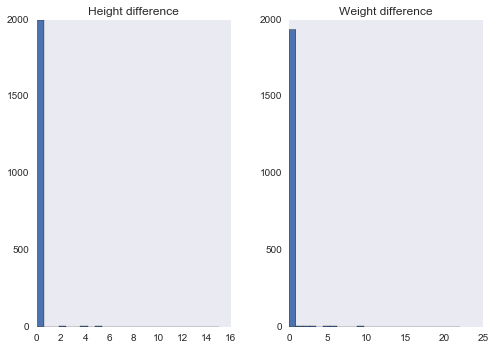

In [9]:
max_diff = data_weight_height.groupby("player").max() - data_weight_height.groupby("player").min()
max_diff.columns = ["Weight difference", "Height difference"]
max_diff.hist(bins=25,grid=False)

In [10]:
weight_diff = max_diff.groupby("Weight difference").count().reset_index()
weight_diff.columns = ["Weight difference", "Number of players"]
weight_diff

,Weight difference,Number of players
0,0.0,1937
1,1.0,2
2,2.0,2
3,3.0,2
4,4.0,1
5,5.0,3
6,6.0,3
7,9.0,2
8,19.0,1
9,22.0,1


In [11]:
height_diff = max_diff.groupby("Height difference").count().reset_index()
height_diff.columns = ["Height difference", "Number of players"]
height_diff

,Height difference,Number of players
0,0.0,1939
1,1.0,1
2,2.0,3
3,3.0,1
4,4.0,2
5,5.0,2
6,7.0,1
7,8.0,1
8,10.0,1
9,11.0,1


We observe that the vast majority of players (> 99%) have the same height/weight in all dyads. There are only a few outliers with up to 15 centimeter and 22 kg difference. We assume that it is acceptable to simply average the weight/height of the players.

### Skin color differences (for the same rater)

We saw that our consistency loop tells us that the skin color rating of the players is not consistent, it seems that the rating may vary from one dyad to another with the same player. This would mean that the data is inconsistent and therefore need to be cleaned. This is why we proceed for a bigger check, to be sure that the values vary and to determine how much they vary.

In [12]:
data_skin = data[["playerShort","rater1", "rater2"]]
std = data_skin.groupby("playerShort").std().reset_index()
std.mean()

rater1    0.0
rater2    0.0
dtype: float64

In [13]:
max_diff = data_skin.groupby("playerShort").max() - data_skin.groupby("playerShort").min()
max_diff.columns = ["Rater 1 difference", "Rater 2 difference"]

In [14]:
rater1_diff = max_diff.groupby("Rater 1 difference").count().reset_index()
rater1_diff.columns = ["Rater 1 difference", "Number of players"]
rater1_diff

,Rater 1 difference,Number of players
0,0.0,1585


In [15]:
rater2_diff = max_diff.groupby("Rater 2 difference").count().reset_index()
rater2_diff.columns = ["Rater 2 difference", "Number of players"]
rater2_diff

,Rater 2 difference,Number of players
0,0.0,1585


We see that the differences in rating is actually null. The function we used to check if the data is consistent is not robust and returned fals for the ratings because of some corner case. The skin color ratings therefore needs no cleaning.

### Skin color differences (between the two raters)

The two columns, rater1 and rater2, represents the skin rating of player by the two raters (5-point scale ranging from “very light skin” to “very dark skin”).   
We want to ensure the rating makes sense and that the differences between the two raters are not to significant.    

We therefore compute the differences between the two raters and print a histogram.


,raterDiff,occurrences
0,-0.50,164
1,-0.25,23830
2,0.00,95714
3,0.25,4913


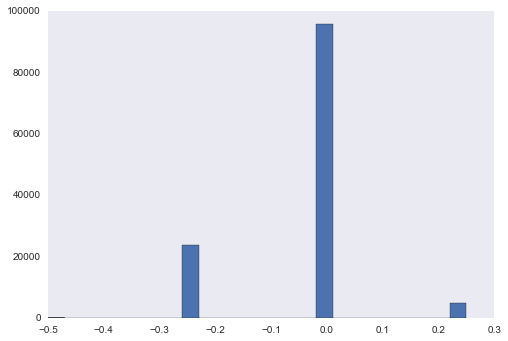

In [16]:
#Takes only skin color ratings
raterData = data[['rater1','rater2']]
raterData = raterData.dropna(axis=0, how="any")
#Compute differences between the two raters
raterData['raterDiff']=(raterData.rater1-raterData.rater2)
#Display histogram
raterData.raterDiff.hist(bins=25,grid=False)
#Display array with differences
Diff = pd.DataFrame(raterData.groupby('raterDiff').count()["rater1"].reset_index())
Diff.columns =["raterDiff", "occurrences"]
Diff

In [17]:
matchRate = Diff[Diff.raterDiff == 0].occurrences / sum(Diff.occurrences) * 100
m05diff = Diff[Diff.raterDiff == -0.5].occurrences / sum(Diff.occurrences) * 100
m025diff = Diff[Diff.raterDiff == -0.25].occurrences / sum(Diff.occurrences) * 100
p025diff = Diff[Diff.raterDiff == 0.25].occurrences / sum(Diff.occurrences) * 100
print("The two rating match for %2.1f%% of the players" %matchRate)
print("Rater1 rates 2 point lighter for %2.1f%% of the players" %m05diff)
print("Rater1 rates 1 point lighter for %2.1f%% of the players" %m025diff)
print("Rater2 rates 1 point lighter for %2.1f%% of the players" %p025diff)

The two rating match for 76.8% of the players
Rater1 rates 2 point lighter for 0.1% of the players
Rater1 rates 1 point lighter for 19.1% of the players
Rater2 rates 1 point lighter for 3.9% of the players


We observe that the skin ratings matches for **76.8%** of the players. The rater1 has a higher tendancy to rate the skin color lighter thant the rater2, he does it for **19.1%** of the players. on the other hands, it is rare that rater2 gives a lighter rate than rater1, only for **3.9%** of the players. It almost never happens that the differences is two points, only for **0.1%** of the players, and there is no case of 3 or 4 points differences.


These values shows that there is no complete incoherrent rating on the overall skin rating data, there is no need to clean them.

## Data Cleaning

In order to clean the data, we first check where are unknown values

In [18]:
for feature in data:
    if data[feature].isnull().any():
        print(feature, "has null value(s)")

height has null value(s)
weight has null value(s)
position has null value(s)
photoID has null value(s)
rater1 has null value(s)
rater2 has null value(s)
Alpha_3 has null value(s)
meanIAT has null value(s)
nIAT has null value(s)
seIAT has null value(s)
meanExp has null value(s)
nExp has null value(s)
seExp has null value(s)


We observe that a few columns contains unkown values.   

### Height and Weight values
Since we will later aggregate the data by players, we will have the possibility of averaging the heights and weights of players and not taking the null value into account, we then decide to let them untouched for the moment

In [19]:
data[data["height"].isnull()].shape

(263, 28)

In [20]:
data[data["weight"].isnull()].shape

(2243, 28)

### Position
There is a significant amount of unkown position for players. We accept to have unknown values for the player position and we can treat them later when we aggregate the players.   

In [21]:
data[data["position"].isnull()].shape

(17726, 28)

### Skin color
The skin color of the player, indicated by **rater1** and **rater2** are absolutely necessary to train and test our model.    
We evaluate the number of unknown skin color rate and check that it corresponds to the players with no picture.

In [22]:
data[data["rater1"].isnull()].shape

(21407, 28)

In [23]:
data[data["rater1"].isnull()].shape == data[data["rater2"].isnull()].shape

True

In [24]:
data[data["rater1"].isnull()].shape == data[data["photoID"].isnull()].shape

True

We decide then to remove the players with unknown skin type.

In [25]:
data_clean = data.dropna(subset=['rater1', 'rater2'])
len(data_clean)

124621

### Implicit and Explicit bias score

We evaluate the values of the implicit and explicit bias score to determine how much values are missing

In [26]:
data_clean[data_clean["meanIAT"].isnull()].shape

(153, 28)

In [27]:
data_clean[data_clean["meanIAT"].isnull()].shape == data_clean[data_clean["nIAT"].isnull()].shape

True

In [28]:
data_clean[data_clean["meanIAT"].isnull()].shape == data_clean[data_clean["seIAT"].isnull()].shape

True

In [29]:
data_clean[data_clean["meanIAT"].isnull()].shape == data_clean[data_clean["meanExp"].isnull()].shape

True

In [30]:
data_clean[data_clean["meanIAT"].isnull()].shape == data_clean[data_clean["nExp"].isnull()].shape

True

In [31]:
data_clean[data_clean["meanIAT"].isnull()].shape == data_clean[data_clean["seExp"].isnull()].shape

True

We observe that only 153 entries have missing values.   
We will now try to determine if we can obtain these values or not.

In [32]:
data_clean[data_clean["meanIAT"].isnull()].groupby("Alpha_3").size()

Alpha_3
ANT       2
Mali     49
NAM      11
QAT      90
dtype: int64

In [33]:
data_clean[data_clean["Alpha_3"] == 'ANT']["meanIAT"].unique()

array([ nan])

In [34]:
data_clean[data_clean["Alpha_3"] == 'Mali']["meanIAT"].unique()

array([ nan])

In [35]:
data_clean[data_clean["Alpha_3"] == 'NAM']["meanIAT"].unique()

array([ nan])

In [36]:
data_clean[data_clean["Alpha_3"] == 'QAT  ']["meanIAT"].unique()

array([ nan])

We observe that those unknown unkown values can't be found anywhere else in the data. We were also unable to find these values on the web, and therefore chose to discard the rows with unkown bias

In [37]:
data_clean = data_clean.dropna(subset=["meanIAT"])
len(data_clean)

124468

In [38]:
for feature in data_clean:
    if data_clean[feature].isnull().any():
        print(feature, "has null value(s)")

height has null value(s)
weight has null value(s)
position has null value(s)


### Players position

We expect to see difference in terms of cards receive by players, according to their position on the field (Defender usually receives more than attacker or goalkeeper). We want to check it to be sure.

In [39]:
positions = data_clean.position.unique()
positions

array(['Attacking Midfielder', 'Right Winger', 'Center Back',
       'Left Fullback', 'Defensive Midfielder', 'Goalkeeper',
       'Right Fullback', 'Left Winger', nan, 'Left Midfielder',
       'Center Midfielder', 'Right Midfielder', 'Center Forward'], dtype=object)

We compute the average cards received per game by player according to their position. We use the position with the most yellow cards per game as the reference.

In [40]:
cards_position = data_clean.groupby("position")[["yellowCards","yellowReds","redCards"]].mean()
games_position = data_clean.groupby("position")[["games"]].mean()
cards_position_average = cards_position.div(games_position["games"],axis='rows').sort_values(by="yellowCards",ascending=False)
print("Reference cards received per game:")
reference = cards_position_average.iloc[0]
reference.to_frame()

Reference cards received per game:


,Defensive Midfielder
yellowCards,0.188480
yellowReds,0.006289
redCards,0.004146


Then we display the average cards received per game rate for each position, compared to the reference.

In [41]:
cards_position_standard = cards_position_average / reference
cards_position_standard

,yellowCards,yellowReds,redCards
position,,,
Defensive Midfielder,1.000000,1.000000,1.000000
Right Fullback,0.871192,0.875094,0.921046
Center Back,0.849468,0.938681,1.593623
Center Midfielder,0.815983,0.700489,0.921910
Left Fullback,0.784848,0.748161,1.107614
Right Midfielder,0.681209,0.542404,0.608833
Left Midfielder,0.669579,0.703263,0.905495
Attacking Midfielder,0.656140,0.447389,0.609219
Left Winger,0.602994,0.406481,0.649901


We clearly see, as expected that the defender and midfielder receives significantly more yellow and yellowReds cards.   

We observe also that the direct red cards does not follow the same kind of distribution, and that the difference is less clear between defender/midfielder and goalkeeper/attacker.

This clearly shows that **the cards received strongly depends on the players position** (at least for yellow and yellowRed cards), therefore we must keep this information in our data if we want to provide a proper classifier.

## Aggregation of the data

### Player data

There are some players data we're not interested in, for example, we can drop their name (column "player"), because they are uniquely identified by their short name (column "playerShort"). We are also not interested in the pictures. We then drop these two features.

In [42]:
data_clean = data_clean.drop(["player", "photoID"], axis=1)

### Referees info

Since we decided to aggregate the data by players, we can drop the referee information, therefore, we drop the columns:
* refNum
* refCountry

In [43]:
data_clean = data_clean.drop(["refNum", "refCountry"], axis=1)

We want to keep the implicit and explicit bias score information. We therefore need to combine the values of all referees for each players.

We want to simplify our lives and simply compute the average of the mean bias score of each referee as follow:
\begin{equation}
Mean_{I/E} (p) = \frac{1}{G(p)} \sum_{r\in R(P)} Mean_{I/E} (r) \cdot G(r,p)
\end{equation}

- $Mean_{I/E} (p)$ The equivalent mean implicit or explicit score for a player p
- $Mean_{I/E} (r)$ The mean implicit or explicit score for a referee r
- $G(p)$ is the number of games played by player p
- $G(r,p)$ is the number of game with referee r and player p
- $R(p)$ is the set of referee that encountered player p

In [ ]:
data_clean_with_player_bias = data_clean.copy()
data_clean_with_player_bias["meanIAT"] = data_clean_with_player_bias["meanIAT"]*data_clean_with_player_bias["games"]
data_clean_with_player_bias["meanExp"] = data_clean_with_player_bias["meanExp"]*data_clean_with_player_bias["games"]

We do not take into account the sample size and standard error for bias score, assuming that the mean will be sufficient to give enough information. We therefore drop those columns

In [51]:
data_clean_with_player_bias = data_clean_with_player_bias.drop(["nIAT", "seIAT", "nExp", "seExp"], axis=1)

### Aggregation

In [65]:
data_grouped = data_clean_with_player_bias.groupby(["playerShort","club","leagueCountry","birthday","position"])

In [66]:
len(data_grouped)==len(data_clean_with_player_bias.groupby(["playerShort"]))

True

In [67]:
agg_functions = {'height' : np.mean, 'weight' : np.mean, 'games' : np.sum, 'victories' : np.sum, 
                 'ties' : np.sum, 'defeats' : np.sum, 'goals' : np.sum, 'yellowCards' : np.sum, 
                 'redCards' : np.sum, 'rater1' : np.mean, 'rater2' : np.mean, 'meanIAT' : np.sum, 
                 'meanExp' : np.sum}

In [70]:
data_aggregation = data_grouped.agg(agg_functions)
data_aggregation[["meanIAT","meanExp"]] = data_aggregation[["meanIAT","meanExp"]].div(data_aggregation["games"], axis="rows")
data_aggregation

,,,,,yellowCards,redCards,rater1,goals,victories,meanExp,games,ties,meanIAT,height,defeats,rater2,weight
playerShort,club,leagueCountry,birthday,position,,,,,,,,,,,,,
aaron-hughes,Fulham FC,England,08.11.1979,Center Back,19,0,0.25,9,247,0.400637,654,179,0.333195,182.0,228,0.00,71.0
aaron-hunt,Werder Bremen,Germany,04.09.1986,Attacking Midfielder,42,1,0.00,62,141,0.380811,336,73,0.341438,183.0,122,0.25,73.0
aaron-lennon,Tottenham Hotspur,England,16.04.1987,Right Midfielder,11,0,0.25,31,200,0.399459,412,97,0.332389,165.0,115,0.25,63.0
aaron-ramsey,Arsenal FC,England,26.12.1990,Center Midfielder,31,1,0.00,39,150,0.433294,260,42,0.336638,178.0,68,0.00,76.0
abdelhamid-el-kaoutari,Montpellier HSC,France,17.03.1990,Center Back,8,2,0.25,1,41,0.328895,124,40,0.331882,180.0,43,0.25,73.0
abdou-traore_2,Girondins Bordeaux,France,17.01.1988,Right Midfielder,11,0,0.75,3,41,0.317247,97,23,0.327985,180.0,33,0.75,74.0
abdoulaye-diallo_2,Stade Rennes,France,30.03.1992,Goalkeeper,0,0,0.75,0,8,0.428271,24,8,0.343556,189.0,8,1.00,80.0
abdoulaye-keita_2,Girondins Bordeaux,France,19.08.1990,Goalkeeper,0,0,0.75,0,0,0.390184,3,1,0.348498,188.0,2,1.00,83.0
abdoulwhaid-sissoko,Stade Brest,France,20.03.1990,Defensive Midfielder,21,2,1.00,3,34,0.402314,121,25,0.344130,180.0,62,1.00,68.0
